<a href="https://www.kaggle.com/code/lonnieqin/house-prices-prediction-with-kerastuner?scriptVersionId=114915127" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## House Price Regression with KerasTuner
## Table of Contents
- Summary
- Import Packages
- Import Datasets
- Common Functions
- Exploratory Data Analysis & Data Preprocessing
    - Statistic infos
    - Missing Value Imputation
    - Convert Categorical Features to Numerical Features
    - Train Validation Split
    - Calculate Correlated Features
    - Feature Scaling
- Model Development
- Submission


## Summary
In this notebook, I will demonstrate using Keras Tuner to do hyper parameter tuning in House Price Prediction Problems.

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np
import keras_tuner as kt
from tensorflow import keras
import matplotlib.pyplot as plt
import math
from tensorflow.keras.callbacks import LearningRateScheduler

## Import Datasets

In [2]:
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")


## Common Functions

**Evaluation Function**

In [3]:
def evaluate(model, x_val, y_val):
    y_pred = model.predict(x_val).reshape(y_val.shape)
    r2 = metrics.r2_score(y_val, y_pred)
    mse = metrics.mean_squared_error(y_val, y_pred)
    mae = metrics.mean_absolute_error(y_val, y_pred)
    msle = metrics.mean_squared_log_error(y_val, y_pred)
    mape = np.mean(keras.metrics.mean_absolute_percentage_error(y_val, y_pred).numpy())
    rmse = np.sqrt(mse)
    rmlse_score = rmlse(y_val, y_pred).numpy()
    print("R2 Score:", r2)
    print("MSE:", mse)
    print("MAE:", mae)
    print("MSLE:", msle)
    print("MAPE", mape)
    print("RMSE:", rmse)
    print("RMLSE", rmlse_score)
    return {"r2": r2, "mse": mse, "mae": mae, "msle": msle, "mape": mape, "rmse": rmse, "rmlse": rmlse_score}


**Root Mean Squared Logarithmic Error**

In [4]:
def rmlse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(tf.math.log(y_pred + 1) - tf.math.log(y_true + 1))))

## Cosine Decay Learning Rate Scheduler

In [5]:
def get_cosine_decay_learning_rate_scheduler(epochs, cycles=1, lr_start=0.001, lr_end=0.0002):
    def cosine_decay(epoch):
        epochs_per_cycle = epochs // cycles
        epoch_in_cycle = epoch % epochs_per_cycle
        if epochs_per_cycle > 1:
            w = (1 + math.cos(epoch_in_cycle / (epochs_per_cycle-1) * math.pi)) / 2
        else:
            w = 1
        return w * lr_start + (1 - w) * lr_end
    return LearningRateScheduler(cosine_decay, verbose=0)

**Submission**

In [6]:
def submit(model, X, ids, file_path):
    SalePrice = model.predict(X)
    submission = pd.DataFrame({"Id": ids, "SalePrice": SalePrice.reshape(-1)})
    submission.to_csv(file_path, index=False)

## Exploratory Data Analysis & Data Preprocessing

In [7]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
train.shape

(1460, 81)

**Statistic infos**

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [10]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


**Correlation scores**

In [11]:
correlation_scores = train.corr()
correlation_scores

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


**Factors that impact house price most**

In [12]:
train.corr()["SalePrice"].sort_values(key = lambda x: abs(x), ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass      -0.084284
OverallCond     -0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold          -0.028923
LowQualFinSF    -0.025606
Id              -0.021917
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
Name: SalePr

### Missing Value Imputation

I will use following strategies to apply imputation to missing values. 
- For numerical columns, I will replace missing value with their mean value.
- For categorical columns, I will replace missing value with unknown category.

In [13]:
for data in [train, test]:
    null_counts = data.isnull().sum()
    null_counts[null_counts > 0]
    null_columns = list(pd.DataFrame(null_counts[null_counts > 0]).index)
    for column in null_columns:
        if data[column].dtype == object:
            data[column] = data[[column]].replace(np.NAN, "Unknown")
        else:
            data[column] = data[column].replace(np.NAN, data[column].mean())

### Convert Categorical Features to Numerical Features

In [14]:
train_test = pd.get_dummies(pd.concat([train, test]))

In [15]:
train_test.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_New,SaleType_Oth,SaleType_Unknown,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,0,0,0,1,0,0,0,0,1,0


In [16]:
mean_value = train_test.mean()
std_value = train_test.std()
mean_value.pop("SalePrice")
std_value.pop("SalePrice")
print(mean_value)
print(std_value)

Id                        1460.000000
MSSubClass                  57.137718
LotFrontage                 69.315409
LotArea                  10168.114080
OverallQual                  6.089072
                             ...     
SaleCondition_AdjLand        0.004111
SaleCondition_Alloca         0.008222
SaleCondition_Family         0.015759
SaleCondition_Normal         0.822885
SaleCondition_Partial        0.083933
Length: 312, dtype: float64
Id                        842.787043
MSSubClass                 42.517628
LotFrontage                21.314457
LotArea                  7886.996359
OverallQual                 1.409947
                            ...     
SaleCondition_AdjLand       0.063996
SaleCondition_Alloca        0.090317
SaleCondition_Family        0.124562
SaleCondition_Normal        0.381832
SaleCondition_Partial       0.277335
Length: 312, dtype: float64


In [17]:
train_features = train_test.iloc[0: len(train)]
test_features = train_test.iloc[len(train):]
_ = train_features.pop("Id")
_ = test_features.pop("SalePrice")
test_ids = test_features.pop("Id")

### Train Validation Split

In [18]:
train_features, val_features = train_test_split(train_features, test_size=0.2, random_state=np.random.randint(1000))

### Calculate Correlated Features

In [19]:
train_features.corr()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_Unknown,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
MSSubClass,1.000000,-0.355810,-0.175923,0.047600,-0.051423,0.023558,0.046027,0.044778,-0.089376,-0.093469,...,-0.063115,-0.036599,NaN,0.036247,0.013160,0.007243,0.021335,0.013579,0.030541,-0.067965
LotFrontage,-0.355810,1.000000,0.327123,0.229324,-0.073986,0.111787,0.061869,0.181406,0.272170,0.072461,...,0.131445,-0.006081,NaN,-0.087194,-0.012190,-0.021765,-0.014474,0.028334,-0.088662,0.130486
LotArea,-0.175923,0.327123,1.000000,0.124830,-0.013233,0.011080,0.025737,0.103022,0.222548,0.133198,...,0.027011,-0.001657,NaN,-0.008099,-0.026334,-0.014812,0.009383,-0.010298,0.001492,0.025854
OverallQual,0.047600,0.229324,0.124830,1.000000,-0.087295,0.564999,0.550663,0.393523,0.286409,-0.047619,...,0.320685,-0.048526,NaN,-0.213073,-0.092057,-0.053350,-0.035061,-0.021068,-0.149070,0.319403
OverallCond,-0.051423,-0.073986,-0.013233,-0.087295,1.000000,-0.386699,0.066265,-0.130130,-0.067890,0.033367,...,-0.158676,-0.021837,NaN,0.162972,-0.049964,-0.042211,-0.023524,-0.046243,0.174709,-0.160453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SaleCondition_AdjLand,0.007243,-0.021765,-0.014812,-0.053350,-0.042211,-0.060567,-0.044935,-0.030058,-0.037812,-0.014636,...,-0.015272,-0.002102,NaN,0.019702,-0.013944,1.000000,-0.004716,-0.005788,-0.108701,-0.015443
SaleCondition_Alloca,0.021335,-0.014474,0.009383,-0.035061,-0.023524,-0.016320,-0.021041,-0.003343,-0.005237,-0.026801,...,-0.027966,-0.003849,NaN,0.036079,-0.025535,-0.004716,1.000000,-0.010599,-0.199059,-0.028280
SaleCondition_Family,0.013579,0.028334,-0.010298,-0.021068,-0.046243,-0.005377,-0.028981,-0.001579,0.034035,-0.025137,...,-0.034326,-0.004724,NaN,0.044284,-0.031342,-0.005788,-0.010599,1.000000,-0.244325,-0.034710
SaleCondition_Normal,0.030541,-0.088662,0.001492,-0.149070,0.174709,-0.170981,-0.127499,-0.081089,-0.069299,0.046571,...,-0.644655,-0.088716,NaN,0.639675,-0.588611,-0.108701,-0.199059,-0.244325,1.000000,-0.651876


In [20]:
thresold = 0.05
correlated_scores = train_features.corr()["SalePrice"]
correlated_scores = correlated_scores[correlated_scores.abs() >= thresold]
correlated_columns = list(correlated_scores.index)
correlated_columns.remove("SalePrice")
print(correlated_columns)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'Alley_Grvl', 'Alley_Unknown', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LotConfig_CulDSac', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NoRid

In [21]:
train_targets = train_features.pop("SalePrice")
val_targets = val_features.pop("SalePrice")

### Feature Scaling

In [22]:
categorical_columns = set(train.dtypes[train.dtypes==object].index)

In [23]:
scale_strategies = ["none", "standard_scale", "standard_scale_exclude_categorcial_features"]
scale_strategy = scale_strategies[2]
if scale_strategy == scale_strategies[1]:
    train_features = (train_features - mean_value) / std_value
    val_features = (val_features - mean_value) / std_value
    test_features = (test_features - mean_value) / std_value
if scale_strategy == scale_strategies[2]:
    for column in train_features.columns:
        is_categorical_feature = False
        components = column.split("_")
        if len(components) == 2 and components[0] in categorical_columns:
            is_categorical_feature = True
        if is_categorical_feature == False:
            for features in [train_features, val_features, test_features]:
                features.loc[:, column] = (features.loc[:, column] - mean_value[column]) / std_value[column]

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [24]:
train_features.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_Unknown,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
363,2.419286,-2.266791,-1.076216,-0.063174,2.187904,0.022687,1.088119,2.282993,-0.613397,-0.293086,...,0,0,0,1,0,0,0,0,1,0
246,3.124875,-0.014798,-0.130102,-0.063174,2.187904,-2.024096,-1.639892,-0.572132,-0.969025,-0.293086,...,0,0,0,1,0,0,0,0,1,0
1393,3.124875,-0.437047,0.080117,-0.063174,1.289537,-2.189159,0.753100,-0.572132,-0.969025,-0.293086,...,0,0,0,1,0,0,0,0,1,0
851,1.478499,0.034462,-0.884001,1.355319,-0.507197,1.046078,0.896679,-0.348201,-0.969025,-0.293086,...,0,0,0,1,0,0,0,0,1,0
49,-0.873466,-0.155547,-0.307609,-0.772420,1.289537,-0.175389,-0.874135,-0.572132,0.705937,-0.293086,...,0,0,0,1,0,0,0,0,1,0


In [25]:
use_correlated_columns = True
if use_correlated_columns:
    train_features = train_features[correlated_columns]
    val_features = val_features[correlated_columns]
    test_features = test_features[correlated_columns]

## Model Development and Evaluation

## Build the Model

In [26]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.Input((train_features.shape[1])))
    for depth in range(hp.Choice('depth', [3, 4, 5, 6, 7])):
        model.add(keras.layers.Dense(hp.Choice('width', [4, 8, 16, 32, 64]), activation=hp.Choice('activation', ["relu", "elu", "tanh", "selu", "sigmoid"]), kernel_regularizer=keras.regularizers.l2()))
    model.add(keras.layers.Dense(1))
    adam = keras.optimizers.Adam(learning_rate=hp.Choice("learing_rate", [1e-3, 5e-3, 1e-4, 5e-4, 1e-5]))
    model.compile(loss='mse', optimizer=adam, metrics=["mae", rmlse])
    return model

Trial 100 Complete [00h 00m 01s]
val_rmlse: 9.257379531860352

Best val_rmlse So Far: 12.012216567993164
Total elapsed time: 00h 03m 02s


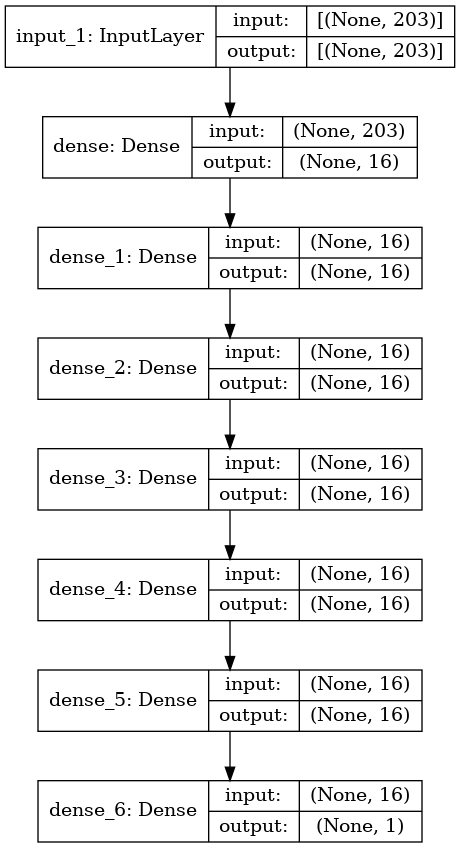

In [27]:
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_rmlse", direction="min"),
    max_trials=100)
tuner.search(train_features, train_targets, epochs=10, validation_data=(val_features, val_targets))
best_model = tuner.get_best_models()[0]
keras.utils.plot_model(best_model, show_shapes=True)

Epoch 1/300
37/37 [==============================] - 1s 7ms/step - loss: 42195401674.1053 - mae: 185453.8627 - rmlse: 11.9267 - val_loss: 36015648768.0000 - val_mae: 175290.7812 - val_rmlse: 10.2759
Epoch 2/300
37/37 [==============================] - 0s 2ms/step - loss: 39527289155.3684 - mae: 181007.4864 - rmlse: 8.8081 - val_loss: 35566415872.0000 - val_mae: 174087.7188 - val_rmlse: 4.9236
Epoch 3/300
37/37 [==============================] - 0s 2ms/step - loss: 38768832188.6316 - mae: 177883.8072 - rmlse: 4.0193 - val_loss: 24537939968.0000 - val_mae: 141827.4688 - val_rmlse: 1.6164
Epoch 4/300
37/37 [==============================] - 0s 2ms/step - loss: 17735607619.3684 - mae: 112384.9803 - rmlse: 1.0666 - val_loss: 2356169728.0000 - val_mae: 41447.1836 - val_rmlse: 0.2780
Epoch 5/300
37/37 [==============================] - 0s 2ms/step - loss: 2047854989.4737 - mae: 34626.7041 - rmlse: 0.2346 - val_loss: 1218473856.0000 - val_mae: 24457.8398 - val_rmlse: 0.1786
Epoch 6/300
37/37 [

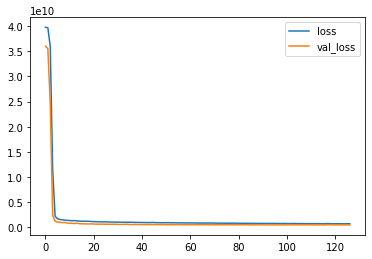

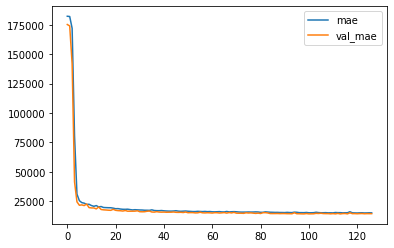

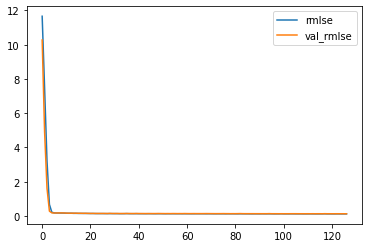

In [28]:
epochs = 300
early_stop = keras.callbacks.EarlyStopping(monitor="val_rmlse", mode="min", patience=10)
scheduler = get_cosine_decay_learning_rate_scheduler(epochs)
model_checkpoint_path = "model.h5"
model_checkpoint = keras.callbacks.ModelCheckpoint(model_checkpoint_path, monitor="val_rmlse", mode="min", save_best_model=True, restore_best_weights=True)
history = best_model.fit(train_features, train_targets, epochs=epochs, validation_data=(val_features, val_targets), callbacks=[early_stop, scheduler, model_checkpoint])
for metric in ["loss", "mae", "rmlse"]:
    pd.DataFrame(history.history, columns=[metric, "val_" + metric]).plot()
    plt.show()

## Submission

In [29]:
SalePrice = best_model.predict(test_features).reshape(-1)
submission = pd.DataFrame({"Id": test_ids, "SalePrice": SalePrice})
submission.to_csv("submission.csv", index=False)


## If you found my work useful, please give me an upvote, thanks.